In [63]:
import sys 
import pdb
import torch
import torch.utils.data
from torchvision import datasets, transforms
import torch.optim as optim
from attrdict import AttrDict
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import importlib
import numpy as np

#sys.path.append('../data/Hasy/')
sys.path.append('../')


In IPython Kernel


In [64]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore') 

In [65]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set Params 

In [66]:
outdir = '../out/mnist/'
modeldir = '../models/mnist/'

# Just needed for data loading, really
args = AttrDict({'batch_size': 256,
                 'lr': 0.001,
                 'momentum': 0.5,
                 'epochs': 10,
                 'log_interval': 10})

# Reproducibility
np.random.seed(2018)

### Load Data

In [67]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=False)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=False)

In [68]:
# Grab a batch for experiments
batch_x, batch_y = next(iter(train_loader))

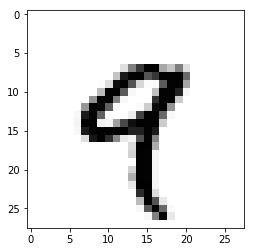

In [69]:
idx = 4
plt.imshow(batch_x[idx].squeeze(), cmap = 'Greys')

### Load Classifier

In [70]:
from src.models import image_classifier

classifier = torch.load(os.path.join(modeldir, "classif.pth"))

#classifier = image_classifier.load(os.path.join(ckpdir, "classif.pth"))

### Load Masked Classifier

In [71]:
import src.models
importlib.reload(src.models)
from src.models import masked_image_classifier

mask_size = (7,7)

## If cpu (old loading format)
model_path = os.path.join(modeldir, "mask_model_{}x{}.pth").format(*mask_size)
mask_model = torch.load(model_path)

## If gpu (old loading format)
model_path = os.path.join(modeldir, "mask_model_{}x{}.pth").format(*mask_size)
mask_model = torch.load(model_path, map_location=lambda storage, location: storage)

# New loading function (both cpu and gpu)
#mask_model = masked_image_classifier.load(model_path)


### Explain!

In [72]:
importlib.reload(matplotlib)
matplotlib.use('PS')

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

import src.utils
importlib.reload(src.utils)

import src.explainers
importlib.reload(src.explainers)
from src.explainers import MCExplainer

classes = [str(i) for i in range(10)]

alpha = 1
p = 2
Exp = MCExplainer(classifier,
                  mask_model,
                  classes = classes,
                  loss_type = 'norm_delta',
                  alpha = alpha,
                  p     = p,
                  plot_type = 'treemap')

# 12, 25, 30
idx = 63
x  = batch_x[idx:idx+1]
print(classes_tex[batch_y[idx].item()])

fx = classifier(x)
p, pred = fx.max(1)

plt.imshow(x.squeeze(), cmap='Greys')
plt.title('Prediction: ' + classes_tex[pred] + ' (class no.{})'.format(pred.item()), fontsize = 20)
plt.xticks([])
plt.yticks([])
plt.show()


e = Exp.explain(x, pred.item(), verbose = 0 , show_plot = 0)
save_path = None
save_path = os.path.join(outdir, 'expl_id-{}_alpha-{}.pdf'.format(idx, crit_alpha, crit_p))
e.plot(save_path = save_path)

In IPython Kernel
In IPython Kernel


TypeError: __init__() got an unexpected keyword argument 'crit_alpha'

# Try different explanation scoring functions

In [73]:
importlib.reload(src.explainers)
from src.explainers import MCExplainer
classes = [str(i) for i in range(10)]

In IPython Kernel


 Pick a digit!

In [74]:
idx = 12

3


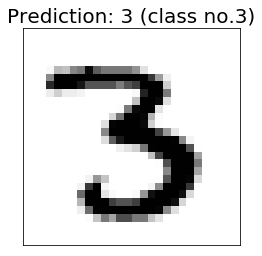

In [75]:
x  = batch_x[idx:idx+1]
print(classes_tex[batch_y[idx].item()])
fx = classifier(x)
p, pred = fx.max(1)
plt.imshow(x.squeeze(), cmap='Greys')
plt.title('Prediction: ' + classes_tex[pred] + ' (class no.{})'.format(pred.item()), fontsize = 20)
plt.xticks([])
plt.yticks([])
plt.show()

### Let's start with the "monotonous decay" scoring function

Large value of alpha: less regularization towards half-sized paritions => shorter explanation

3
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Prediction: 3 (class no.3)
Explanation step:  0
Best objective:   0.1091 (i =  7, j = 10)
Explanation step:  1
Best objective:  -0.4780 (i = 12, j = 12)
Done!


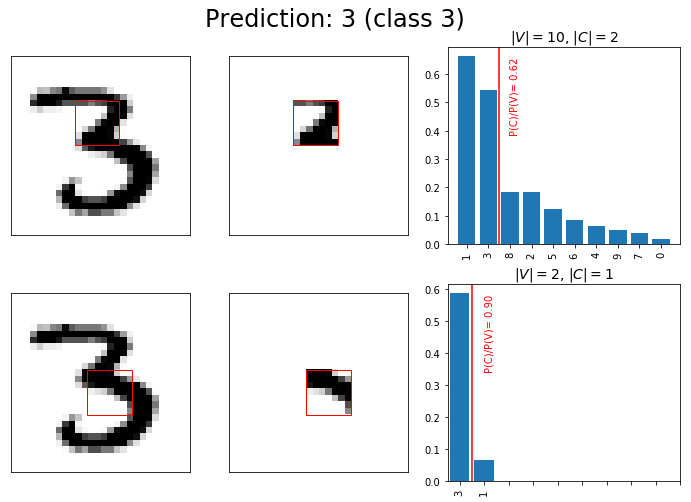

In [79]:
loss_type  = 'norm_delta'
reg_type   = 'decay'
alpha      = 1
p          = 2

Exp = MCExplainer(classifier,
                  mask_model,
                  classes    = classes,
                  loss_type  = 'norm_delta',
                  alpha      = alpha,
                  p          = p,
                  plot_type = 'bar')

e = Exp.explain(x, pred.item(), verbose = 0 , show_plot = 0)
save_path = None
save_path = os.path.join(outdir, 'expl_id-{}_alpha-{}.pdf'.format(idx, crit_alpha, crit_p))
e.plot(save_path = save_path, plot_type = 'bar')

Large value of alpha: more regularization towards half-sized paritions => longer explanation

3
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Prediction: 3 (class no.3)
Explanation step:  0
Best objective:  -0.1584 (i = 10, j = 17)
Explanation step:  1
Best objective:  -1.1162 (i = 16, j = 13)
Explanation step:  2
Best objective:  -4.3156 (i =  7, j =  6)
Done!


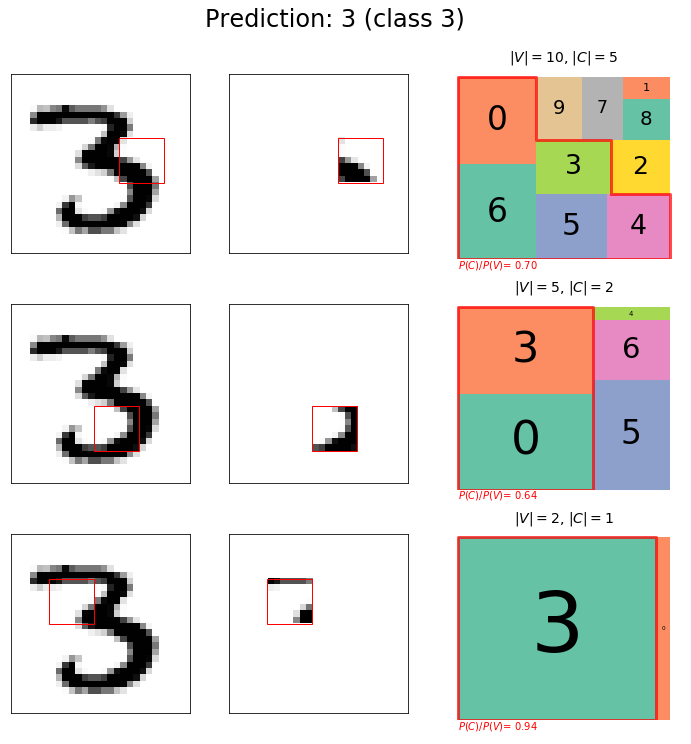

In [55]:
loss_type  = 'norm_delta'
reg_type   = 'decay'
alpha      = 5
p          = 2

Exp = MCExplainer(classifier,
                  mask_model,
                  classes    = classes,
                  loss_type  = 'norm_delta',
                  alpha      = alpha,
                  p          = p,
                  plot_type = 'treemap')

e = Exp.explain(x, pred.item(), verbose = 0 , show_plot = 0)
save_path = None
save_path = os.path.join(outdir, 'expl_id-{}_alpha-{}.pdf'.format(idx, crit_alpha, crit_p))
e.plot(save_path = save_path)

### Now, the "centered polynomial" scoring function

Small alpha

3
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Prediction: 3 (class no.3)
Explanation step:  0
Best objective:   0.2986 (i =  7, j = 10)
Explanation step:  1
Best objective:   0.4220 (i = 12, j = 12)
Done!


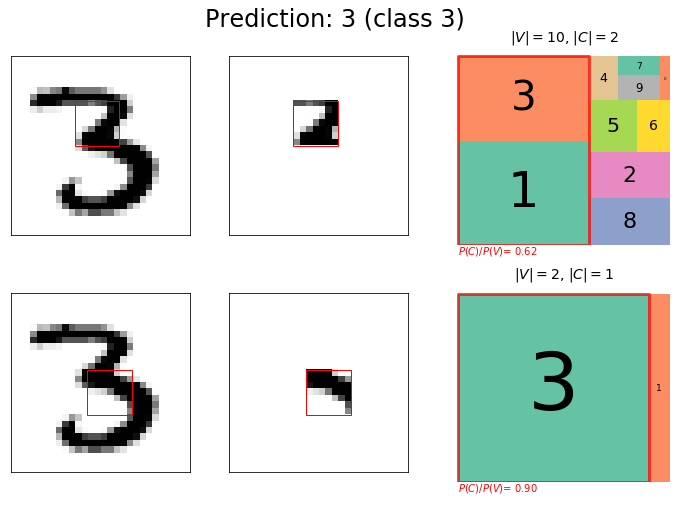

In [61]:
loss_type  = 'norm_delta'
reg_type   = 'poly-centered'
alpha      = .1
p          = 2

Exp = MCExplainer(classifier,
                  mask_model,
                  classes    = classes,
                  loss_type  = 'norm_delta',
                  reg_type   = reg_type,
                  alpha      = alpha,
                  p          = p,
                  plot_type = 'treemap')


e = Exp.explain(x, pred.item(), verbose = 0 , show_plot = 0)
save_path = None
save_path = os.path.join(outdir, 'expl_id-{}_alpha-{}.pdf'.format(idx, crit_alpha, crit_p))
e.plot(save_path = save_path)

Large alpha

3
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Prediction: 3 (class no.3)
Explanation step:  0
Best objective:  -0.0202 (i = 10, j = 17)
Explanation step:  1
Best objective:  -1.1162 (i = 16, j = 13)
Explanation step:  2
Best objective:  -4.3156 (i =  7, j =  6)
Done!


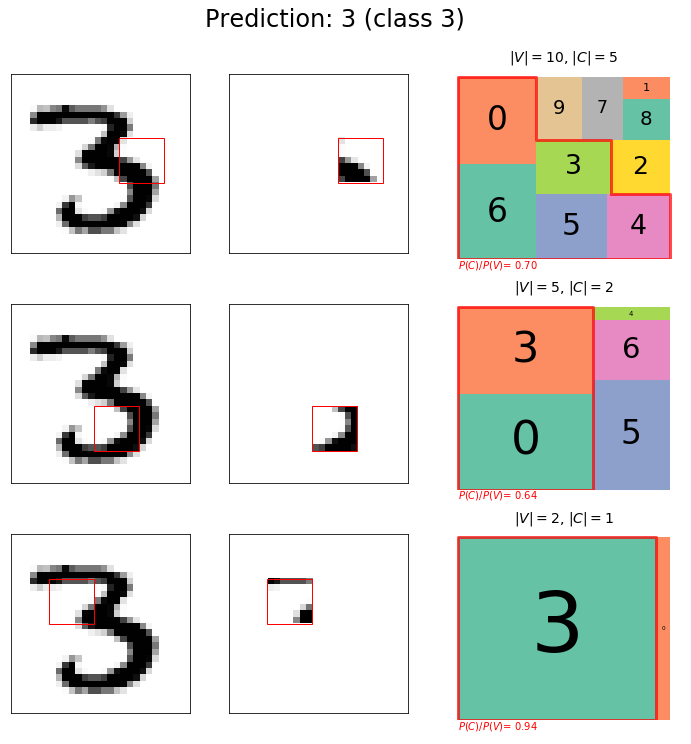

In [62]:
loss_type  = 'norm_delta'
reg_type   = 'poly-centered'
alpha      = 5
p          = 2

Exp = MCExplainer(classifier,
                  mask_model,
                  classes    = classes,
                  loss_type  = 'norm_delta',
                  reg_type   = reg_type,
                  alpha      = alpha,
                  p          = p,
                  plot_type = 'treemap')

e = Exp.explain(x, pred.item(), verbose = 0 , show_plot = 0)
save_path = None
save_path = os.path.join(outdir, 'expl_id-{}_alpha-{}.pdf'.format(idx, crit_alpha, crit_p))
e.plot(save_path = save_path)